In [13]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef



data = pd.read_csv('D:\iith\python_scripts\Randam_Features.csv')

# Split the dataset into features (X) and the target (y)
X = data.drop(columns=["Sequence_ID", "Sequence", "Anti_aging","Unnamed: 0", 'Molecular_formula', 'Length'])
y = data['Anti_aging']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


# Initialize the LGBMClassifier
model = LGBMClassifier(boosting_type='dart',
                        n_estimators=100,
                        learning_rate=0.01,
                        max_depth=6,
                        drop_rate=0.3,
                        skip_drop=0.5,
                        num_leaves = 31,
                        verbosity = -1,
                        random_state=45)

<>:14: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Aryan\AppData\Local\Temp\ipykernel_31924\1946220841.py:14: SyntaxWarning: invalid escape sequence '\i'
  data = pd.read_csv('D:\iith\python_scripts\Randam_Features.csv')


In [3]:
#Running model with all features
model.fit(X_train, y_train)

#predicting on test set
y_pred = model.predict(X_test)

# Evaluate the model on the training set
test_accuracy_1 = accuracy_score(y_test, y_pred)
test_precision_1 = precision_score(y_test, y_pred, average='binary', pos_label=1)
test_recall_1 = recall_score(y_test, y_pred, average='binary', pos_label=1)
test_f1_1 = f1_score(y_test, y_pred, average='binary', pos_label=1)
test_mcc_1 = matthews_corrcoef(y_test, y_pred)

# Calculate specificity for the training set
conf_matrix = confusion_matrix(y_test, y_pred)
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
specificity_1 = TN / (TN + FP)


#predicting on the train set itself
y_train_pred = model.predict(X_train)

# Evaluate the model on the training set
train_accuracy_1 = accuracy_score(y_train, y_train_pred)
train_precision_1 = precision_score(y_train, y_train_pred, average='binary', pos_label=1)
train_recall_1 = recall_score(y_train, y_train_pred, average='binary', pos_label=1)
train_f1_1 = f1_score(y_train, y_train_pred, average='binary', pos_label=1)
train_mcc_1 = matthews_corrcoef(y_train, y_train_pred)

# Calculate specificity for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_TN = train_conf_matrix[0, 0]
train_FP = train_conf_matrix[0, 1]
train_specificity_1 = train_TN / (train_TN + train_FP)

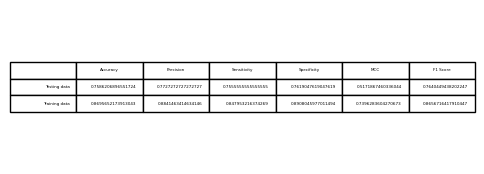

In [4]:
data_1 = {
   '' : ['Testing data', 'Training data'],
   'Accuracy' : [test_accuracy_1, train_accuracy_1],
   'Precision' : [test_precision_1, train_precision_1],
   'Sensitivity' : [test_recall_1, train_recall_1],
   'Specificity' : [specificity_1, train_specificity_1],
   'MCC' : [test_mcc_1, train_mcc_1],
   'F1 Score' : [test_f1_1, train_f1_1]
}

df = pd.DataFrame(data_1)

fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Create a table
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# Save as PNG
plt.savefig("lgbm_results_wo_rfe.png", bbox_inches='tight', dpi=300)
plt.show()

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Recursive Feature Elimination with Cross Validation (RFECV)
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy', n_jobs=-1, min_features_to_select=20)

# Fit the model
rfecv.fit(X, y)

selected_columns = X.columns[rfecv.support_].tolist()

# Print results
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected Features: {selected_columns}")


# make new datasets with selected features
X_train_rfe = rfecv.transform(X_train)
X_test_rfe = rfecv.transform(X_test)
X_rfe = rfecv.transform(X) 

#fitting model into the rfe dataset
model.fit(X_train_rfe, y_train)



Optimal number of features: 24
Selected Features: ['Charge', 'Charge_density', 'Isoelectric_point', 'Aromaticity', 'Aliphatic_index', 'Hydrophobic_ratio', 'AAC_C', 'AAC_D', 'AAC_G', 'AAC_H', 'AAC_N', 'AAC_Y', 'PCP_NE', 'PCP_AL', 'PCP_NT', 'PCP_SC', 'PCP_SS_ST', 'PCP_SA_IN', 'PCP_LR', 'PCP_Z1', 'PCP_Z2', 'PCP_Z3', 'PCP_Z4', 'PAAC1_lam1']


LGBMClassifier(boosting_type='dart', drop_rate=0.3, learning_rate=0.01,
               max_depth=6, random_state=45, skip_drop=0.5, verbosity=-1)

In [15]:
pd.DataFrame(selected_columns, columns=["Selected Features"]).to_csv("selected_features_lgbm_rfecv.csv", index=False)

In [16]:
y_pred = model.predict(X_test_rfe)

# Evaluate the model on the training set
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
test_recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
test_f1 = f1_score(y_test, y_pred, average='binary', pos_label=1)
test_mcc = matthews_corrcoef(y_test, y_pred)
# Calculate specificity for the training set
conf_matrix = confusion_matrix(y_test, y_pred)
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
specificity = TN / (TN + FP)

# Print results for the training set
print(f'Test Set Accuracy: {test_accuracy:.2f}')
print(f'Test Set Precision: {test_precision:.2f}')
print(f'Test Set Sensitivity (Recall): {test_recall:.2f}')
print(f'Test Set Specificity: {specificity:.2f}')
print(f'Test Set F1 Score: {test_f1:.2f}')

Test Set Accuracy: 0.80
Test Set Precision: 0.82
Test Set Sensitivity (Recall): 0.80
Test Set Specificity: 0.81
Test Set F1 Score: 0.81


In [17]:
#Make predictions on the training data
y_train_pred = model.predict(X_train_rfe)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='binary', pos_label=1)
train_recall = recall_score(y_train, y_train_pred, average='binary', pos_label=1)
train_f1 = f1_score(y_train, y_train_pred, average='binary', pos_label=1)
train_mcc = matthews_corrcoef(y_train, y_train_pred)

# Calculate specificity for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_TN = train_conf_matrix[0, 0]
train_FP = train_conf_matrix[0, 1]
train_specificity = train_TN / (train_TN + train_FP)

# Print results for the training set
print(f'Training Set Accuracy: {train_accuracy:.2f}')
print(f'Training Set Precision: {train_precision:.2f}')
print(f'Training Set Sensitivity (Recall): {train_recall:.2f}')
print(f'Training Set Specificity: {train_specificity:.2f}')
print(f'Training Set F1 Score: {train_f1:.2f}')

Training Set Accuracy: 0.84
Training Set Precision: 0.87
Training Set Sensitivity (Recall): 0.81
Training Set Specificity: 0.88
Training Set F1 Score: 0.84


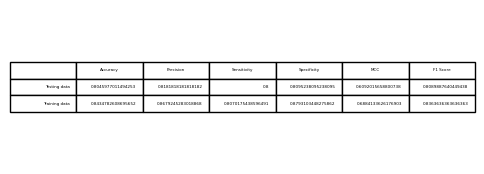

In [18]:

data = {
   '' : ['Testing data', 'Training data'],
   'Accuracy' : [test_accuracy, train_accuracy],
   'Precision' : [test_precision, train_precision],
   'Sensitivity' : [test_recall, train_recall],
   'Specificity' : [specificity, train_specificity],
   'MCC' : [test_mcc, train_mcc],
   'F1 Score' : [test_f1, train_f1]
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Create a table
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# Save as PNG
plt.savefig("lgbm_results_rfecv.png", bbox_inches='tight', dpi=300)
plt.show()

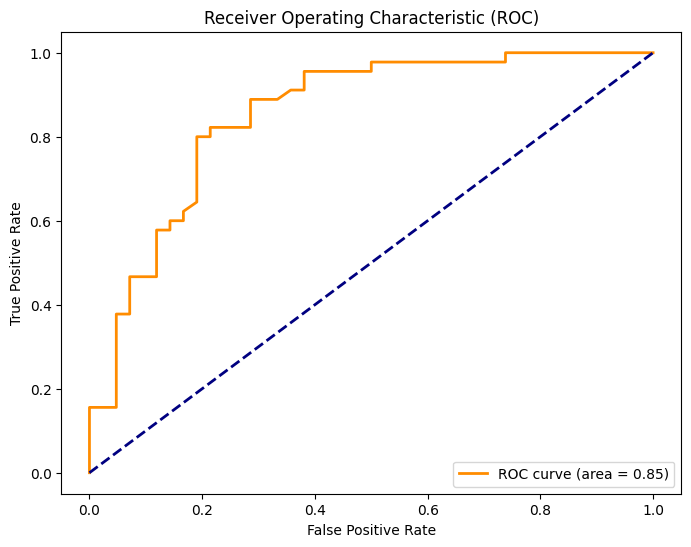

In [19]:
#making an roc-auc curve
y_pred_proba = model.predict_proba(X_test_rfe)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_plot = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_plot:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform cross-validation for X after RFE
scores = cross_val_score(model, X_rfe, y, cv=sss, scoring='f1')

print("Cross-validation scores:", scores)
print("Mean f1 score with RFE:", scores.mean())

Cross-validation scores: [0.78571429 0.71604938 0.73809524 0.81395349 0.74358974]
Mean f1 score with RFE: 0.759480427697482


In [25]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, 
					ignore_warnings=False, 
					custom_metric=None) 

# fitting data in LazyClassifier 
models, predictions = clf.fit(X_train_rfe, X_test_rfe, 
							y_train, y_test) 



models.to_csv('D:\iith\python_scripts\model_rank_randam_lgbrfecv.csv')

<>:13: SyntaxWarning: invalid escape sequence '\i'
<>:13: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Aryan\AppData\Local\Temp\ipykernel_31924\3604075769.py:13: SyntaxWarning: invalid escape sequence '\i'
  models.to_csv('D:\iith\python_scripts\model_rank_randam_lgbrfecv.csv')
 29%|██▉       | 9/31 [00:00<00:00, 26.14it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 74%|███████▍  | 23/31 [00:00<00:00, 30.27it/s]

StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 31/31 [00:01<00:00, 26.99it/s]
